## EDA - Amazon Buy Box Algo Modelling

In [1]:
import pandas as pd 
import numpy as np
from collections import defaultdict
from matplotlib.ticker import FuncFormatter
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

In [2]:
import matplotlib.pyplot as plt

### A. Loading/Cleaning Data

In [3]:
# loading crawl2 data
crawl2 = pd.read_table("crawl2.txt")

In [4]:
# read in prime sids and algo seller sids
prime_sids = pd.read_table("prime_sids.txt", header=None, names=["prime_sids"])
algo_sellers = pd.read_table("susp_sids_all_with_amazon.txt", header=None, names=["algo_sids"])

In [5]:
# rename columns and merge prime/algo lists
crawl2.columns = ["pid", "epoc", "sid", "price", "sid_rating", "sid_pos_fb", "sid_rating_cnt", "shipping", "page", "rank", "pid_rating", "pid_rating_cnt", "is_fba", "is_prime", "bbox_sid", "bbox_price"]
crawl2["prime_seller"] = crawl2["sid"].isin(prime_sids["prime_sids"])
crawl2["algo_seller"] = crawl2["sid"].isin(algo_sellers["algo_sids"])

In [6]:
# how many unique pids?
unique_pids = crawl2["pid"].unique().tolist()
unique_pids
len(unique_pids)

987

In [7]:
# code for sampling data (for testing code)
sample_ids = np.random.choice(unique_pids, size=400, replace = False)
crawl_data_sample = crawl_data[crawl_data["pid"].isin(sample_ids)]

NameError: name 'crawl_data' is not defined

In [ ]:
# list of pids sorted in descending order by num of sellers
pidsandcount = crawl2.groupby("pid").agg({"pid" : "count"})
pidsandcount.columns = ["count"]
pidsandcount = pidsandcount.reset_index().sort_values(by="count", ascending=False)
pidsandcount.head(5)

,pid,count
600,B009IH0BYQ,30140
255,B001EOV492,30110
159,B000NCOKZQ,30110
681,B00DJPK8PA,30110
63,B0002E1P08,30100


In [ ]:
# copy data and add timestamp column from epoc
crawl_data = crawl2.copy()
crawl_data["timestamp"] = pd.to_datetime(crawl2['epoc'].astype(float), unit='s')
crawl_data

,pid,epoc,sid,price,sid_rating,sid_pos_fb,sid_rating_cnt,shipping,page,rank,pid_rating,pid_rating_cnt,is_fba,is_prime,bbox_sid,bbox_price,prime_seller,algo_seller,timestamp
0,0975277324,1439301853,A19HZ7QWHIRFQA,35.00,0.0,0,0,6.49,1,7,5.0,2321,yes,no,amazon,40.36,False,False,2015-08-11 14:04:13
1,0975277324,1439301853,A1G1QJKXJJSAN2,44.06,5.0,98,3761,3.99,2,9,5.0,2321,no,no,amazon,40.36,False,False,2015-08-11 14:04:13
2,0975277324,1439301853,A1H9LQ4XQ5IZ7D,39.99,5.0,97,1577,0.00,1,1,5.0,2321,yes,yes,amazon,40.36,True,False,2015-08-11 14:04:13
3,0975277324,1439301853,A1OUQ84L1EU4IB,36.99,5.0,100,2,6.49,2,1,5.0,2321,no,no,amazon,40.36,False,False,2015-08-11 14:04:13
4,0975277324,1439301853,A1PSEM5PTWSZBK,39.95,4.5,85,5308,6.10,2,4,5.0,2321,no,no,amazon,40.36,False,False,2015-08-11 14:04:13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20740262,B01387NUN0,1440712515,A8UMA0WO93O39,5.95,5.0,100,3,0.00,1,1,1.0,3,no,no,A8UMA0WO93O39,5.95,False,False,2015-08-27 21:55:15
20740263,B01387NUN0,1440712515,AB62NOZUAODRB,10.99,5.0,100,770,4.75,1,9,1.0,3,no,no,A8UMA0WO93O39,5.95,False,False,2015-08-27 21:55:15
20740264,B01387NUN0,1440712515,AC9XK46ZTUENH,6.00,5.0,100,6,4.50,1,6,1.0,3,no,no,A8UMA0WO93O39,5.95,False,False,2015-08-27 21:55:15
20740265,B01387NUN0,1440712515,AS94HDKW3U98F,10.49,0.0,0,0,0.00,1,5,1.0,3,no,no,A8UMA0WO93O39,5.95,False,False,2015-08-27 21:55:15


### B. Recreating Figure 2 - CDF of Interval Between Changes for Sellers, Buybox Sellers, and Buybox Price

In [ ]:
def calculate_inter_update_times(df):
    # group by each product
    product_groups = df.groupby('pid')
    seller_price_update_times = []
    bbox_price_update_times = []
    bbox_seller_update_times = []

    
    for pid, group in product_groups:
        group = group.sort_values('timestamp')
        
        last_price_update = defaultdict(lambda: None)
        last_bbox_price = None
        last_bbox_seller = None
        
        for _, row in group.iterrows():
            timestamp = row['timestamp']
            seller_id = row['sid']
            bbox_price = row['bbox_price']
            bbox_seller = row['bbox_sid']
            
            # calc seller price update time
            if last_price_update[seller_id] is not None:
                time_diff = (timestamp - last_price_update[seller_id]).total_seconds()
                seller_price_update_times.append(time_diff)
            
            # calc buy box price update time
            if last_bbox_price is not None and bbox_price != last_bbox_price:
                time_diff = (timestamp - last_bbox_price[1]).total_seconds()
                bbox_price_update_times.append(time_diff)
                last_bbox_price = (bbox_price, timestamp)
            elif last_bbox_price is None:
                last_bbox_price = (bbox_price, timestamp)
            
            # calc buy box seller update time
            if last_bbox_seller is not None and bbox_seller != last_bbox_seller[0]:
                time_diff = (timestamp - last_bbox_seller[1]).total_seconds()
                bbox_seller_update_times.append(time_diff)
                last_bbox_seller = (bbox_seller, timestamp)
            elif last_bbox_seller is None:
                last_bbox_seller = (bbox_seller, timestamp)
            
            # update last price update time for this seller
            last_price_update[seller_id] = timestamp
    
    return seller_price_update_times, bbox_price_update_times, bbox_seller_update_times

In [ ]:
def plot_cumulative_distribution(seller_times, bbox_price_times, bbox_seller_times, save_path=None):
    seller_times = sorted(seller_times)
    bbox_price_times = sorted(bbox_price_times)
    bbox_seller_times = sorted(bbox_seller_times)
    
    seller_y = np.arange(1, len(seller_times) + 1) / len(seller_times)
    bbox_price_y = np.arange(1, len(bbox_price_times) + 1) / len(bbox_price_times)
    bbox_seller_y = np.arange(1, len(bbox_seller_times) + 1) / len(bbox_seller_times)
    
    fig, ax = plt.subplots()
    
    # convert times from seconds to minutes for plotting
    seller_times_min = [t / 60 for t in seller_times]
    bbox_price_times_min = [t / 60 for t in bbox_price_times]
    bbox_seller_times_min = [t / 60 for t in bbox_seller_times]
    
    # plot cumulative distributions
    ax.plot(seller_times_min, seller_y, 'b-', label='Seller Price Updates')
    ax.plot(bbox_price_times_min, bbox_price_y, 'g-', label='Buy Box Price Updates')
    ax.plot(bbox_seller_times_min, bbox_seller_y, 'r-', label='Buy Box Seller Updates')
    
    # cet log scale for x-axis
    ax.set_xscale('log')
    
    # format y-axis as percentage
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    
    # add labels and title
    ax.set_xlabel('Inter-Update Time (minutes, log scale)')
    ax.set_ylabel('Cumulative Percentage')
    ax.set_title('Figure 2: Cumulative Distribution of Inter-Update Times')
    
    # add grid and legend
    ax.grid(True, alpha=0.3)
    ax.legend(loc='lower right')
    
    # customize x-axis ticks
    time_ticks = [1/60, 1/6, 1, 10, 60, 6*60, 24*60]
    time_labels = ['1s', '10s', '1m', '10m', '1h', '6h', '24h']
    ax.set_xticks(time_ticks)
    ax.set_xticklabels(time_labels)
    
    # set axis limits
    min_time = min(bbox_seller_times_min)
    max_time = max([max(seller_times_min), max(bbox_price_times_min), max(bbox_seller_times_min)])
    ax.set_xlim(min_time * 0.8, max_time * 1.2)
    

In [ ]:
seller_times, bbox_price_times, bbox_seller_times = calculate_inter_update_times(crawl_data)

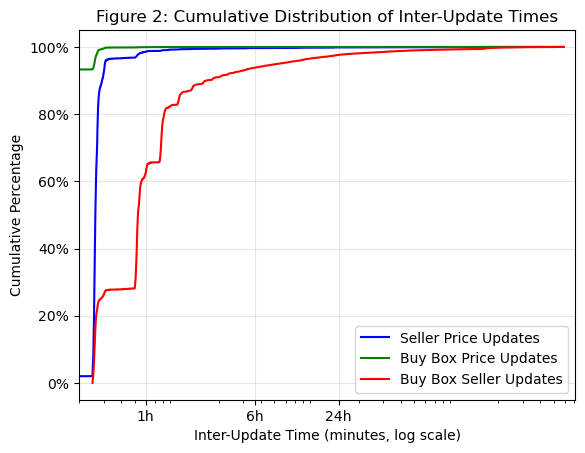

In [ ]:
plot_cumulative_distribution(seller_times, bbox_price_times, bbox_seller_times)

### B. Recreating Figure 9 - Probability of Winning Buy Box by Rank

In [ ]:
# calculate winrate by rank
crawl_data["wonbbox"] = crawl_data["bbox_sid"] == crawl_data["sid"]
crawl_data_winrate_by_rank = crawl_data.groupby("rank").agg({"wonbbox" : "mean"})
crawl_data_winrate_by_rank

,wonbbox
rank,
0,0.355975
1,0.105770
2,0.051780
3,0.032789
4,0.019421
5,0.014333
6,0.010299
7,0.007691
8,0.006677


Text(0.5, 1.0, 'Probability of Winning Buy Box by Rank')

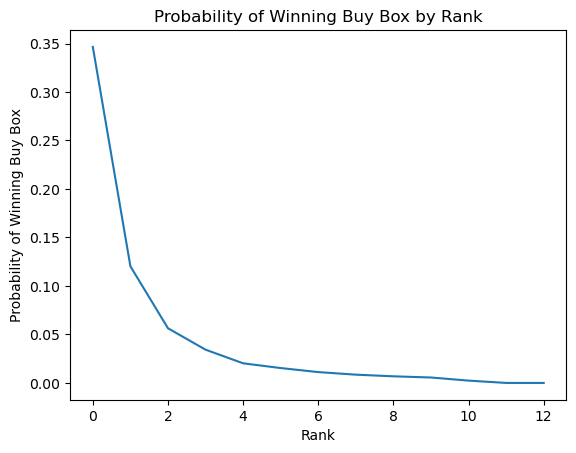

In [ ]:
# plot of winrate by rank
plt.plot(crawl_data_sample_winrate_by_rank.index, crawl_data_sample_winrate_by_rank['wonbbox'], linestyle='-')
plt.xlabel('Rank')
plt.ylabel('Probability of Winning Buy Box')
plt.title('Probability of Winning Buy Box by Rank')

### C. Recreation of RF Classifier - Table 1

In [ ]:
crawl_rf = crawl_data
crawl_rf["price_lowest"] = crawl_data.groupby("pid")["price"].transform("min")
crawl_rf["price_difference_to_lowest"] = crawl_rf["price"] - crawl_rf["price_lowest"]
crawl_rf["price_ratio_to_lowest"] = crawl_rf["price"]/crawl_rf["price_lowest"]
crawl_rf["positive_feedback"] = crawl_rf["sid_pos_fb"]
crawl_rf["is_amazon_seller"] = crawl_rf["sid"] == "amazon"
crawl_rf["feedback_count"] = crawl_rf["sid_rating_cnt"]
crawl_rf["average_rating"] = crawl_rf["sid_rating"]
crawl_rf["is_product_fba"] = crawl_rf["is_fba"] == "yes"
#sampling crawl_rf for faster code
rf_sample_ids = np.random.choice(unique_pids, size=200, replace = False)
crawl_rf_sample = crawl_rf[crawl_rf["pid"].isin(rf_sample_ids)]
X = crawl_rf_sample[["price_difference_to_lowest","price_ratio_to_lowest", "positive_feedback","is_amazon_seller","feedback_count", "average_rating","is_product_fba"]]
y = crawl_rf_sample["wonbbox"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred))

Accuracy: 0.9858
              precision    recall  f1-score   support

       False       0.99      0.99      0.99    761349
        True       0.92      0.88      0.90     58505

    accuracy                           0.99    819854
   macro avg       0.95      0.94      0.95    819854
weighted avg       0.99      0.99      0.99    819854



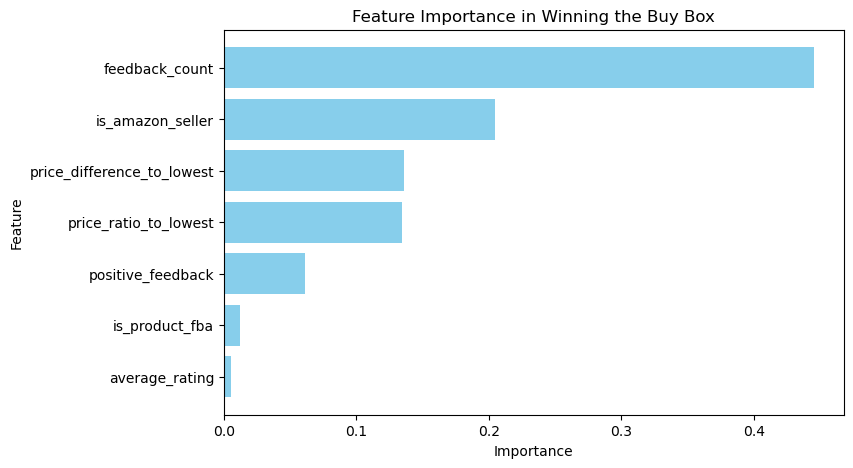

In [ ]:
feature_importances = rf_classifier.feature_importances_
importance_df = pd.DataFrame({'Feature': ["price_difference_to_lowest","price_ratio_to_lowest", "positive_feedback","is_amazon_seller","feedback_count", "average_rating","is_product_fba"], 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(8, 5))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance in Winning the Buy Box")
plt.gca().invert_yaxis()
plt.show()

### D. Recreating Product-Wise Price to find instances of price matching

In [ ]:
unique_pids


['0975277324',
 'B00000J0RJ',
 'B00000JBNX',
 'B00002ND64',
 'B00004R9TL',
 'B00004RBDU',
 'B00004RIZ7',
 'B00004S7V8',
 'B00004SQLJ',
 'B00004TZY8',
 'B00004U9JO',
 'B00004UBGZ',
 'B00004UE29',
 'B00004YO15',
 'B00004YTJE',
 'B00004Z4A8',
 'B00004Z4CP',
 'B00004Z5SM',
 'B000052XHI',
 'B00005BXKM',
 'B00005O6B7',
 'B000067EH7',
 'B000067PCE',
 'B000067PQ0',
 'B000068O36',
 'B000068O3C',
 'B000068PBT',
 'B00006ANDK',
 'B00006I551',
 'B00006IBYA',
 'B00006IDV8',
 'B00006IEE4',
 'B00006IEEU',
 'B00006IEJC',
 'B00006IESK',
 'B00006IFAV',
 'B00006IFH0',
 'B00006IFKU',
 'B00006IUWA',
 'B00006JNN7',
 'B00006WNMJ',
 'B00008Y0VN',
 'B000096QQ5',
 'B00009IMCK',
 'B00009PGNT',
 'B0000AQOH2',
 'B0000AXRH5',
 'B0000CBK1L',
 'B0000YNR4M',
 'B0000YUXI0',
 'B00012YIA0',
 'B00016XJ4M',
 'B000197NXM',
 'B0001DSIVY',
 'B0001J3R3C',
 'B00026ZEDK',
 'B00028XJNA',
 'B00029WYEY',
 'B0002CZW0Y',
 'B0002D0CA8',
 'B0002D0CAI',
 'B0002D0HXA',
 'B0002E1G5C',
 'B0002E1P08',
 'B0002E7DIQ',
 'B0002FOBJY',
 'B0002GLC

### Comparing BuyBox Prices to different Sellers and Amazon

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


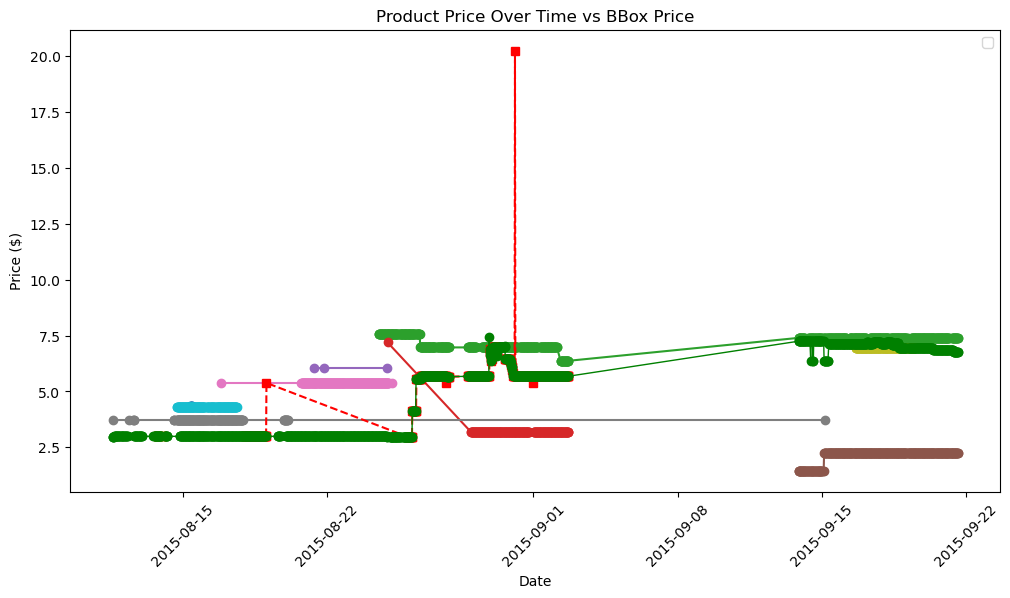

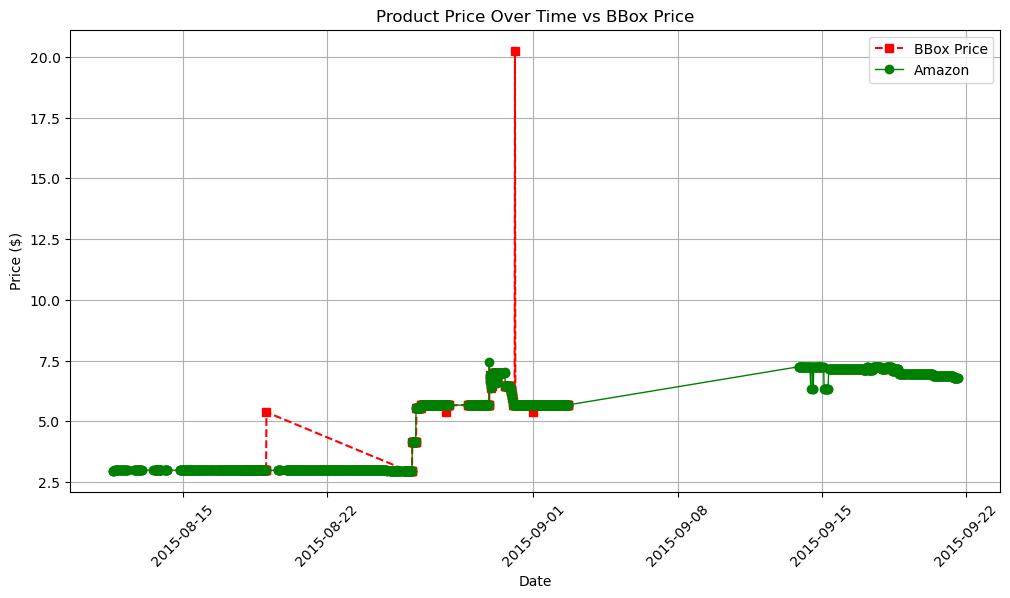

,pid,epoc,sid,price,sid_rating,sid_pos_fb,sid_rating_cnt,shipping,page,rank,pid_rating,pid_rating_cnt,is_fba,is_prime,bbox_sid,bbox_price,prime_seller,algo_seller,date
363810,B00004YO15,1439301853,A1U9TY1Y0UP57H,3.71,4.5,94,16792,4.99,2,8,4.5,714,yes,no,amazon,2.97,False,False,2015-08-11 14:04:13
363811,B00004YO15,1439301853,A270GIASSJQ68C,8.71,4.5,91,3350,0.00,2,9,4.5,714,yes,no,amazon,2.97,False,False,2015-08-11 14:04:13
363812,B00004YO15,1439301853,A2CLSPX77ALNG9,8.09,5.0,100,6097,0.00,1,8,4.5,714,yes,yes,amazon,2.97,True,False,2015-08-11 14:04:13
363813,B00004YO15,1439301853,A2J5IFJG6W8TUT,8.44,5.0,95,468,0.00,2,4,4.5,714,yes,no,amazon,2.97,False,False,2015-08-11 14:04:13
363814,B00004YO15,1439301853,A2P0IMBKY7X8NS,8.13,5.0,99,88506,0.00,2,1,4.5,714,yes,yes,amazon,2.97,True,True,2015-08-11 14:04:13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393725,B00004YO15,1442846263,AI4NR64ERWUIJ,7.45,0.0,0,0,0.00,1,5,4.5,879,yes,yes,amazon,6.77,True,False,2015-09-21 14:37:43
393726,B00004YO15,1442846263,amazon,6.77,5.0,100,4194304,0.00,1,0,4.5,879,yes,yes,amazon,6.77,True,True,2015-09-21 14:37:43
393727,B00004YO15,1442846263,APYBP14X4C82K,7.99,5.0,100,27,0.00,2,1,4.5,879,yes,yes,amazon,6.77,True,False,2015-09-21 14:37:43
393728,B00004YO15,1442846263,ATC02M08QVSX1,8.14,4.5,91,159,0.00,2,7,4.5,879,yes,no,amazon,6.77,False,False,2015-09-21 14:37:43


In [8]:


crawl2["date"] = pd.to_datetime(crawl2["epoc"], unit="s")

pid_sid_dict = crawl2.groupby("pid")["sid"].apply(list).to_dict()
pid_filtered_crawl2 = crawl2[crawl2["pid"]== "B00004YO15"]
amazon = pid_filtered_crawl2[pid_filtered_crawl2["sid"]== "amazon"]
# Sort values by date for better visualization
crawl2 = crawl2.sort_values(by="date")

# Plotting
plt.figure(figsize=(12, 6))
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.title("Product Price Over Time vs BBox Price")
plt.legend()
plt.xticks(rotation=45)
counter = 0
sellerLimit = 10
pid_filtered_crawl2
for sid, sid_df in pid_filtered_crawl2.groupby("sid"):
        if counter == sellerLimit:
                plt.plot(sid_df["date"], sid_df["bbox_price"], label="BBox Price", marker="s", linestyle="--", color="red")
                plt.plot(amazon["date"], amazon["price"], marker="o", linestyle="-", label="Amazon", color="green", linewidth=1)
                plt.figure(figsize=(12, 6))
                plt.plot(sid_df["date"], sid_df["bbox_price"], label="BBox Price", marker="s", linestyle="--", color="red")
                plt.plot(amazon["date"], amazon["price"], marker="o", linestyle="-", label="Amazon", color="green", linewidth=1)
                break
        counter += 1
        plt.plot(sid_df["date"], sid_df["price"], marker="o", linestyle="-")

# Labels and title
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.title("Product Price Over Time vs BBox Price")
plt.legend()
plt.grid(True)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()
pid_filtered_crawl2